In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing, MLtraining
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict

# Diffusion

In [243]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [244]:
feature_column_names=european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns

Dividing the dataset into high and low risk using the PRS scores, thresholded at 0.05.

In [245]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

# Ignore

In [254]:
#Data exploration
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features()),
('scaler',StandardScaler()),
('pca',PCA(n_components=1))])

y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])).reshape(-1)

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)

covariates_statsmodel=sm.add_constant(covariates_statsmodel)
model=sm.OLS(y_statsmodel,covariates_statsmodel).fit()
print(model.summary(xname=['const','Gender','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     26.68
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           3.88e-23
Time:                        23:48:51   Log-Likelihood:                -554.19
No. Observations:                 151   AIC:                             1124.
Df Residuals:                     143   BIC:                             1149.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2696      1.131      2.006      0.0

In [69]:
pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features())])
y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L']))
pipe_stasmodel.named_steps['remove_zero_features'].get_column_names(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns)
y_statsmodel=pd.DataFrame(y_statsmodel)
y_statsmodel.columns=pipe_stasmodel.named_steps['remove_zero_features'].reduced_features_names

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)
model_summary=defaultdict(list)
covariates_statsmodel=sm.add_constant(covariates_statsmodel)
for connection in y_statsmodel.columns:
    model=sm.OLS(y_statsmodel.loc[:,connection],covariates_statsmodel).fit()
    result=[None]*(len(model.params)+len(model.pvalues))
    result[::2]=model.params
    result[1::2]=model.pvalues
    model_summary[connection].extend(result)

model_summary=pd.DataFrame(model_summary).T
list1=['const','Gender','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']
list2=['_coef','_pval']
model_summary.columns=[i+n for i in list1 for n in list2]

In [86]:
model_summary.sort_values(by='PRS_0.05_pval')

,const_coef,const_pval,Gender_coef,Gender_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,Anc_PC1_coef,Anc_PC1_pval,Anc_PC2_coef,Anc_PC2_pval,Anc_PC3_coef,Anc_PC3_pval,PRS_0.05_coef,PRS_0.05_pval
IFGtriang.R_ORBmid.R,0.495145,7.410349e-57,0.049203,0.065700,0.008701,0.604636,0.008174,0.625025,0.006399,0.652591,0.006035,0.650305,0.004184,0.756805,-5.143720e-02,0.000358
DCG.R_INS.R,0.178248,1.502085e-48,0.007475,0.508378,-0.003262,0.647812,0.014591,0.041469,-0.024299,0.000090,-0.011555,0.042524,0.011004,0.056855,-1.812382e-02,0.002887
SMG.L_PCG.L,0.031452,1.008841e-15,0.003198,0.517035,0.003393,0.277323,-0.003370,0.278338,-0.004474,0.091375,0.000615,0.803234,0.002906,0.247481,-7.872742e-03,0.003033
CAU.L_IFGtriang.R,0.008387,1.593129e-24,-0.000975,0.308573,-0.000202,0.738212,0.001208,0.045995,-0.000567,0.268315,-0.000264,0.581551,0.000621,0.202722,-1.513577e-03,0.003275
CAU.L_MFG.R,0.027335,1.446400e-29,-0.001679,0.533464,-0.001654,0.332142,0.005235,0.002374,-0.000748,0.603862,-0.000698,0.605006,0.000645,0.638069,-4.238381e-03,0.003472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SFGmed.L_IFGtriang.R,0.051001,2.012147e-29,0.003210,0.524980,0.001085,0.733677,-0.005465,0.086773,0.002232,0.408695,-0.000093,0.970557,0.002444,0.341484,1.160128e-05,0.996541
TPOmid.R_ROL.R,0.029199,4.712730e-54,-0.005139,0.002262,0.000543,0.604078,-0.001661,0.112239,-0.000127,0.885962,0.000198,0.810859,0.001026,0.223898,3.648522e-06,0.996684
INS.L_PreCG.L,0.813126,5.600237e-96,-0.020262,0.351525,-0.001583,0.908185,0.041802,0.002600,0.016011,0.169330,0.027717,0.011725,-0.004679,0.671762,4.296756e-05,0.997023
HES.R_ORBinf.R,0.004100,3.261112e-35,-0.000404,0.249571,0.000157,0.478304,-0.000824,0.000254,0.000124,0.506699,0.000061,0.729680,0.000015,0.934374,-3.967471e-07,0.998292


In [90]:
# Using NBS on the high and low risk to identify differences in the connections.
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.2)

#regress the connectivity dataset of nuisance regressors: Gender, PMA and GA
covariates=np.asarray(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']])
covariates=np.concatenate((StandardScaler().fit_transform(covariates[:,:2]),LabelBinarizer().fit_transform(covariates[:,-1])),axis=1)

#use all 4005 without removing any zero features
X_total=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L']),covariates)
X_total=StandardScaler().fit_transform(X_total)

X_high_risk=X_total[high_risk,:]
X_low_risk=X_total[low_risk,:]
X_NBS_dataset=np.concatenate([X_high_risk,X_low_risk])

In [92]:
#saving connectivity data
for i in range(X_NBS_dataset.shape[0]):
    np.savetxt('./preprocessed_data/diffusion/term/NBS/connectivity_data/subject_%d.txt'%(i+1),data_preprocessing.reverse_lower_triangle(X_NBS_dataset[i,:],90),fmt='%1.6f')

In [99]:
#design matrix
NBS_design_matrix=np.zeros((X_NBS_dataset.shape[0],2))
NBS_design_matrix[:X_high_risk.shape[0],:]=[0,1]
NBS_design_matrix[X_high_risk.shape[0]:,:]=[1,0]
np.savetxt('./preprocessed_data/diffusion/term/NBS/design_matrix.txt',NBS_design_matrix.astype('int64'),fmt='%i')

In [100]:
#saving nodes label
ROIs=pd.read_csv('./dataset/Regions_of_interests.csv').dropna()
ROIs=ROIs.loc[:,'abbr. '].values
ROIs=[str.split(i,' ')[0] for i in ROIs]
ROIs=['.'.join(str.split(i,'.')) for i in ROIs]

for node in ROIs:
    with open('./preprocessed_data/diffusion/term/NBS/node_labels.txt','a') as file:
        file.write(node+'\n')


In [118]:
# repeating for vol

# Using NBS on the high and low risk to identify differences in the connections.
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.2)

#regress the connectivity dataset of nuisance regressors: Gender, PMA and GA
covariates=np.asarray(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc','Gender']])
covariates=np.concatenate((StandardScaler().fit_transform(covariates[:,:3]),LabelBinarizer().fit_transform(covariates[:,-1])),axis=1)

#use all 4005 without removing any zero features
X_total=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]),covariates)
X_total=StandardScaler().fit_transform(X_total)

X_high_risk=np.corrcoef(X_high_risk,rowvar=False)
X_low_risk=np.corrcoef(X_low_risk,rowvar=False)
np.savetxt('./preprocessed_data/volumetric/term/NBS/connectivity_data/subject_1.txt',X_high_risk,fmt='%1.6f')
np.savetxt('./preprocessed_data/volumetric/term/NBS/connectivity_data/subject_2.txt',X_low_risk,fmt='%1.6f')

#design matrix
np.savetxt('./preprocessed_data/volumetric/term/NBS/design_matrix.txt',np.array(([1,0],[0,1])),fmt='%i')

In [115]:
AAL_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='AAL LEGEND',header=None).drop(0,axis=1)
from string import digits
AAL_label=np.asarray([str.split(i,' ')[1] for i in np.asarray(AAL_label).reshape(-1)])

In [117]:
for node in AAL_label:
    with open('./preprocessed_data/volumetric/term/NBS/node_labels.txt','a') as file:
        file.write(node+'\n')

## Model training

Train model on the bottom 40% (low risk) and perform PRS correlation on the top 20% (high risk)

In [6]:
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)
high_risk=high_risk[2:]
X_total=np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])


y_total=np.asarray(european_diffusion_dataset_term['PMA_diff'])
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_diff'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_diff'])

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import time

In [8]:
covariates=np.asarray(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']])
covariates_low_risk=np.concatenate((StandardScaler().fit_transform(covariates[low_risk,:2]),LabelBinarizer().fit_transform(covariates[low_risk,-1])),axis=1)

PRS_score_scaler=StandardScaler().fit(adjusted_prs_score[low_risk].reshape(-1,1))
adjusted_prs_score_scaled_low_risk=PRS_score_scaler.transform(adjusted_prs_score[low_risk].reshape(-1,1)).reshape(-1)

adjusted_prs_score_scaled_high_risk=PRS_score_scaler.transform(adjusted_prs_score[high_risk].reshape(-1,1)).reshape(-1)

In [9]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=True)),
('select_p_Val',MLtraining.Select_Features_Univariate(adjusted_prs_score_scaled_low_risk,covariates_low_risk))])

X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

2.6067240238189697


## Ridge

In [10]:
from sklearn.linear_model import Lasso

In [11]:
#### with RFECV

In [12]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
inner_fold_feature_selection_logs=defaultdict(list)
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    param_dict=[{'regr__alpha':np.linspace(0.1,100,100)}]
    regr=Ridge()
    pipe1=MLtraining.myPipe([('scaler', StandardScaler()),('regr',regr)])
    grid_search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval)
    pipe1=grid_search.best_estimator_
    rfecv=RFECV(pipe1).fit(X_trainval,y_trainval)
    # sfs=SequentialFeatureSelector(pipe1,cv=inner_cv,direction='backward').fit(X_trainval,y_trainval)
    # pipe1.fit(sfs.transform(X_trainval),y_trainval)
    #normal
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    # y_pred=pipe1.predict(X_test)#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    # with RFECV
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,rfecv.predict(X_trainval))
    y_pred=rfecv.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    #with SFS
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(sfs.transform(X_trainval)))
    # y_pred=pipe1.predict(sfs.transform(X_test))#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    #with RFECV
    inner_fold_feature_selection_logs[i].extend(rfecv.get_support())
    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred
    #with SFS
    # inner_fold_feature_selection_logs[i].extend(sfs.get_support())
    # #use the trained model to predict the brain age (PMA at scan) for high risk subject
    # y_high_risk_pred=pipe1.predict(sfs.transform(X_high_risk_after_pipe0))
    # y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    # y_high_risk_pred_dict[i]=y_high_risk_pred

100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


In [13]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,RMSE,Correlation,p_value
0,0.440944,0.906143,1.128722,0.754683,0.000077
1,0.515118,1.020109,1.213856,0.756575,0.000113
2,0.516621,0.780422,1.070930,0.724241,0.000305
Average,0.490895,0.902225,1.137836,0.745167,0.000165


In [14]:
MLtraining.print_scores(y_high_risk_pred_dict[1],y_high_risk)

{'r2': 0.6673301961149883,
 'MAE': 0.9196180608280206,
 'RMSE': 1.077739713240948,
 'Correlation': 0.840866275933653,
 'p_value': 1.1300287900795846e-08}

Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

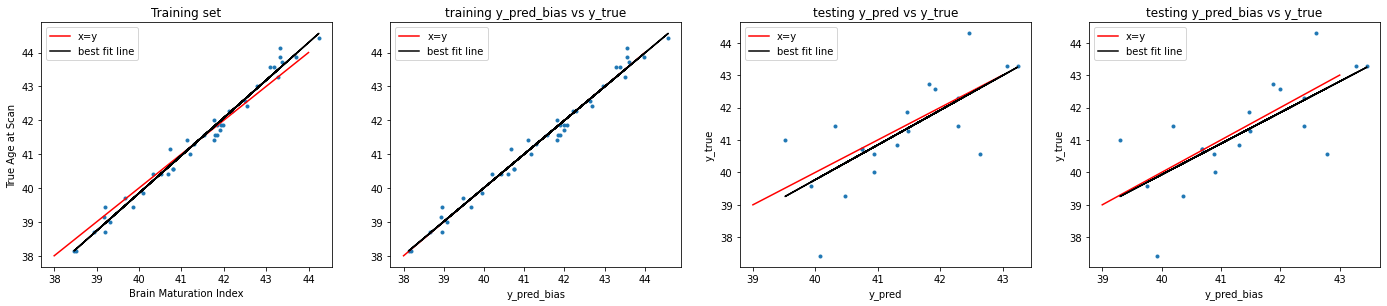

In [15]:
y_train_pred=rfecv.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('True Age at Scan')
ax1.set_xlabel('Brain Maturation Index')
ax1.legend()
ax1.set_title('Training set')

y_pred=rfecv.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



Text(0.5, 1.0, 'Testing dataset (high risk)')

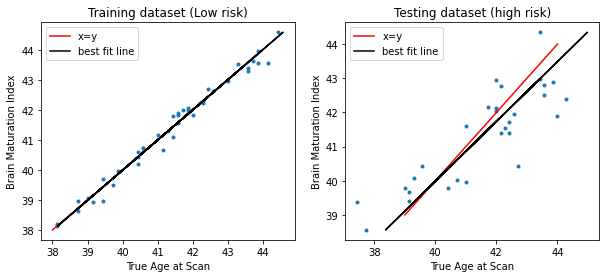

In [17]:
y_train_pred=rfecv.predict(X_trainval)
f,(ax2,ax4)=plt.subplots(1,2,figsize=(10,4))
lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_trainval,y_train_pred_bias,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(lin_reg.predict(y_train_pred_bias.reshape(-1,1)),y_train_pred_bias,'k-',label='best fit line')
ax2.set_xlabel('True Age at Scan')
ax2.set_ylabel('Brain Maturation Index')
ax2.legend()
ax2.set_title('Training dataset (Low risk)')

y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
y_high_risk_pred_bias=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_diff'])
ax4.plot(y_high_risk,y_high_risk_pred_bias,'.')
ax4.plot([39,44],[39,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_high_risk_pred_bias.reshape(-1,1),y_high_risk)
ax4.plot(lin_reg.predict(y_high_risk_pred_bias.reshape(-1,1)),y_high_risk_pred_bias,'k-',label='best fit line')
ax4.set_ylabel('Brain Maturation Index')
ax4.set_xlabel('True Age at Scan')
ax4.legend()
ax4.set_title('Testing dataset (high risk)')

# y_pred_bias=y_pred+y_pred*coef+inter
# ax4.plot(y_test,y_pred_bias,'.')
# ax4.plot([39,44],[39,44],'r-',label='x=y')
# lin_reg=LinearRegression()
# lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
# ax4.plot(lin_reg.predict(y_pred_bias.reshape(-1,1)),y_pred_bias,'k-',label='best fit line')
# ax4.set_ylabel('Brain Maturation Index')
# ax4.set_xlabel('True Age at Scan')
# ax4.legend()
# ax4.set_title('testing dataset')

In [18]:
MLtraining.print_scores(y_high_risk_pred_bias,y_high_risk)

{'r2': 0.695110082708283,
 'MAE': 0.88015343135274,
 'RMSE': 1.0317600941781033,
 'Correlation': 0.8475500596748516,
 'p_value': 6.601471794057649e-09}

In [19]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA,residual
0,42.414008,42.597507,42.505171,42.505562,43.571429,-1.065867
1,40.011881,40.491193,39.974890,40.159321,41.000000,-0.840679
2,40.381565,40.463856,40.420096,40.421839,42.714286,-2.292447
3,40.235064,41.078403,41.547725,40.953731,42.285714,-1.331984
4,41.490902,42.833419,41.884465,42.069595,44.000000,-1.930405
5,41.774034,41.090266,42.123048,41.662450,42.000000,-0.337550
6,42.523774,42.301120,42.761357,42.528750,42.142857,0.385893
7,43.385205,42.760349,42.388732,42.844762,44.285714,-1.440952
8,41.635874,41.532462,42.031504,41.733280,42.000000,-0.266720
9,42.089505,41.173817,41.733265,41.665529,42.428571,-0.763043


In [20]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score_scaled_high_risk))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score_scaled_high_risk))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.546415,0.002164


Text(0.5, 1.0, 'BMI and PMA difference in High risk neonates (diffusion dataset)')

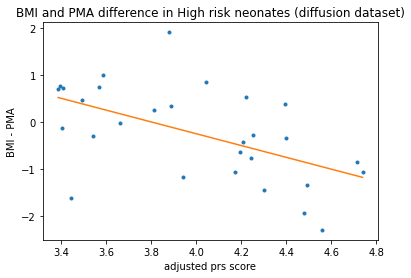

In [21]:
plt.plot(adjusted_prs_score_scaled_high_risk,brain_age_difference['residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score_scaled_high_risk.reshape(-1,1),brain_age_difference['residual'].values)
plt.plot(adjusted_prs_score_scaled_high_risk,lin_reg.predict(adjusted_prs_score_scaled_high_risk.reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.ylabel('BMI - PMA')
plt.title('BMI and PMA difference in High risk neonates (diffusion dataset)')

### Checking features


In [22]:
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)
pipe0.named_steps['remove_correlation'].get_column_names(ROIs_combination_remove_zeros)
ROIs_combination_remove_correlation=pipe0.named_steps['remove_correlation'].reduced_features_names
print(ROIs_combination_remove_correlation.shape)
pipe0.named_steps['select_p_Val'].get_column_names(ROIs_combination_remove_correlation)
ROIs_combination_select_univariate=pipe0.named_steps['select_p_Val'].reduced_features_names
print(ROIs_combination_select_univariate.shape)

(2612,)
(2265,)
(176,)


In [23]:
coefs_of_prs_pval=pipe0.named_steps['select_p_Val'].coefficients[pipe0.named_steps['select_p_Val'].p_value<0.05]

In [24]:
inner_folds_selection=pd.DataFrame(inner_fold_feature_selection_logs)
inner_folds_selection=inner_folds_selection[(inner_folds_selection[0]==True)&(inner_folds_selection[1]==True)&(inner_folds_selection[2]==True)]

In [25]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_select_univariate,coefs_of_prs_pval,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Connection','PRS_coefs','PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3'])
ROIs_coef['PMA_Mean_Coef']=ROIs_coef[['PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3']].mean(axis=1)
# ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['Mean_Coef'].abs().sort_values(ascending=False).index)
ROIs_coef=ROIs_coef.iloc[inner_folds_selection.index,:]

In [26]:
ROIs_coef['PRS*PMA_coefs']=ROIs_coef['PRS_coefs']*ROIs_coef['PMA_Mean_Coef']

In [27]:
ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['PRS*PMA_coefs'].abs().sort_values(ascending=False).index)

In [28]:
merged_feature_dict_strings=pipe0.named_steps['remove_correlation'].merged_feature_dict_strings
ROIs_coef_RidgeCV['Merged_Feature']=[False if not merged_feature_dict_strings[i] else True for i in ROIs_coef_RidgeCV['Connection']]

In [29]:
ROIs_coef_RidgeCV.head(10)

,Connection,PRS_coefs,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef,PRS*PMA_coefs,Merged_Feature
175,ITG.R_FFG.R,-0.508701,0.090283,0.054019,0.048669,0.064324,-0.032722,False
12,ORBinf.R_IFGtriang.R,-0.253258,0.056650,0.065139,0.085570,0.069120,-0.017505,False
31,ACG.L_SFGmed.L,-0.305479,0.036752,0.050740,0.078790,0.055427,-0.016932,False
120,PUT.L_CAU.L,-0.216864,0.079204,0.065787,0.072727,0.072573,-0.015738,False
27,REC.R_ORBsumed.R,-0.127701,0.075955,0.086024,0.054481,0.072154,-0.009214,False
35,DCG.L_ACG.L,-0.138139,0.043613,0.056789,0.086801,0.062401,-0.008620,False
75,SMG.L_PoCG.L,-0.164323,0.054836,0.028413,0.043466,0.042239,-0.006941,False
160,STG.L_HES.L,-0.166892,0.033711,0.038086,0.049916,0.040571,-0.006771,False
123,PUT.R_ORBinf.R,-0.108751,0.043865,0.059202,0.042683,0.048584,-0.005283,False
53,FFG.R_IOG.R,-0.170566,0.015627,0.026823,0.050299,0.030916,-0.005273,False


In [32]:
ROIs_coef_RidgeCV

,Connection,PRS_coefs,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef,PRS*PMA_coefs,Merged_Feature
175,ITG.R_FFG.R,-0.508701,0.090283,0.054019,0.048669,0.064324,-3.272165e-02,False
12,ORBinf.R_IFGtriang.R,-0.253258,0.056650,0.065139,0.085570,0.069120,-1.750514e-02,False
31,ACG.L_SFGmed.L,-0.305479,0.036752,0.050740,0.078790,0.055427,-1.693190e-02,False
120,PUT.L_CAU.L,-0.216864,0.079204,0.065787,0.072727,0.072573,-1.573841e-02,False
27,REC.R_ORBsumed.R,-0.127701,0.075955,0.086024,0.054481,0.072154,-9.214112e-03,False
...,...,...,...,...,...,...,...,...
49,MOG.L_REC.L,-0.000359,-0.035801,-0.033448,-0.034164,-0.034471,1.238143e-05,False
63,PoCG.R_REC.R,-0.000363,-0.033627,-0.026221,-0.034862,-0.031570,1.145947e-05,False
77,SMG.R_REC.R,-0.000194,-0.054640,-0.048150,-0.071494,-0.058095,1.126689e-05,False
105,CAU.L_SMG.R,-0.000294,0.031949,0.019875,0.048636,0.033487,-9.831059e-06,False


In [36]:
ROIs_coef_RidgeCV.to_csv('./ROIs_coef_RidgeCV.csv',index=False)

In [40]:
ROIs_coef_RidgeCV[ROIs_coef_RidgeCV['Merged_Feature']==True]

,Connection,PRS_coefs,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef,PRS*PMA_coefs,Merged_Feature
59,PoCG.R_ORBmid.R,-0.000316,-0.041535,-0.027189,-0.069662,-0.046129,0.000015,True


In [41]:
merged_feature_dict_strings['PoCG.R_ORBmid.R']

['PoCG.R_ORBmid.R', 'SMG.R_ORBmid.R']

In [97]:
DAN=['SOG.','MOG.','SPG.','IPL.','SFGdor.','ORBsup.','MFG.','ORBmid.','SFGmed.','ORBsumed.','ORBinf.']# Left middle and superior occipital gyri, parietal gyrus, inferior and superior parietal gyri, middle and superior frontal gyri
CEN=['SFGdor.','MFG.','ORBmid.','']# dorsal lateral prefrontal, posterior parietal cortices####
DMN=['PreCUN.','PCG.','IPL.','MTG.','TPOmid.','ANG.','SFGdor.','ORBsup.','MFG.','ORBmid.','SFGmed.','ORBsumed.']# Precuneus, posterior cingulate gyrus, bilateral inferior parietal, middle temporal, angular, superior frontal, medial frontal gyri
CN=['ACG.','INS.','SFGdor.']# anterior cingulate, bilateral insular cortices, dorsolateral prefrontal cortex
SRN=['ORBsup.','ORBmid.','ORBinf.','ORBsumed.','REC.','ACG.']# ventromedial prefrontal and medial orbital prefrontal cortices, gyrus rectus, pregenual anterior cingulate gyrus
SMN=['PreCG.','PoCG.','SMA.']#primary snesory-motor cortices, precentral and psotcentral gyri, and supplementary motor area
VN=['SOG.','MOG.','IOG.','FFG.','LING.','CUNE.','CAL.','PreCUN.']# occipital gyrus and the tempora-occipital regions along with superior parietal gyrus
AN=['HES.','STG.','TPOsup.','MTG.','TPOmid.','ITG.']# bilateral middle and superior temporal gyri, Heschl's gyrus, temporal pole

In [89]:
def create_network_list(network):
    all_combo=[]
    for node1 in network:
        for node2 in network:
            all_combo.extend(['_'.join([node1+'L',node2+'L']),
        '_'.join([node1+'L',node2+'R']),
        '_'.join([node1+'R',node2+'R']),
        '_'.join([node1+'R',node2+'L'])])
    return all_combo

In [162]:
test_network=create_network_list(SMN)

In [146]:
ROIs_coef_RidgeCV.set_index('Connection',inplace=True)

In [163]:
test=[]
for connection in ROIs_coef_RidgeCV.index:
    if connection in test_network:

        test.append(connection)



In [164]:
ROIs_coef_RidgeCV.loc[test,:]

,PRS_coefs,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef,PRS*PMA_coefs,Merged_Feature
Connection,,,,,,,
SMA.L_PreCG.L,-0.112908,0.018036,0.025749,-0.042829,0.000319,-0.000036,False


# Volumetric

In [226]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [227]:
feature_names_volumetric=european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]

In [228]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

In [229]:
#Data exploration
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features()),
('scaler',StandardScaler()),
('pca',PCA(n_components=1))])

y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"])).reshape(-1)

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)

covariates_statsmodel=sm.add_constant(covariates_statsmodel)
model=sm.OLS(y_statsmodel,covariates_statsmodel).fit()
print(model.summary(xname=['const','Gender','17 ICV (all except bone)','GA_diff','PMA_diff','Anc_PC1','Anc_PC2','Anc_PC3','PRS']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1074.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):          5.99e-123
Time:                        23:26:05   Log-Likelihood:                -220.38
No. Observations:                 151   AIC:                             458.8
Df Residuals:                     142   BIC:                             485.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [240]:
pipe_stasmodel=Pipeline([('remove_zero_features',MLtraining.Retain_non_zero_features()),('scaler',StandardScaler())])
y_statsmodel=pipe_stasmodel.fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]))
pipe_stasmodel.named_steps['remove_zero_features'].get_column_names(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"].columns)
y_statsmodel=pd.DataFrame(y_statsmodel)
y_statsmodel.columns=pipe_stasmodel.named_steps['remove_zero_features'].reduced_features_names

import statsmodels.api as sm

covariates_statsmodel=np.concatenate((LabelBinarizer().fit_transform(np.asarray(european_diffusion_dataset_term[['Gender']]).reshape(-1,1)),StandardScaler().fit_transform(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']]
)),axis=1)
model_summary=defaultdict(list)
covariates_statsmodel=sm.add_constant(covariates_statsmodel)
for connection in y_statsmodel.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"].columns:
    model=sm.OLS(y_statsmodel.loc[:,connection],covariates_statsmodel).fit()
    result=[None]*(len(model.params)+len(model.pvalues))
    result[::2]=model.params
    result[1::2]=model.pvalues
    model_summary[connection].extend(result)

model_summary=pd.DataFrame(model_summary).T
list1=['const','Gender','17 ICV (all except bone)','GA_struc','PMA_struc','Anc_PC1','Anc_PC2','Anc_PC3','PRS_0.05']
list2=['_coef','_pval']
model_summary.columns=[i+n for i in list1 for n in list2]

In [241]:
model_summary.sort_values(by='PRS_0.05_pval')

,const_coef,const_pval,Gender_coef,Gender_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,GA_struc_coef,GA_struc_pval,PMA_struc_coef,PMA_struc_pval,Anc_PC1_coef,Anc_PC1_pval,Anc_PC2_coef,Anc_PC2_pval,Anc_PC3_coef,Anc_PC3_pval,PRS_0.05_coef,PRS_0.05_pval
'1 Precentral_L 2001',-0.006962,0.892210,0.013832,0.855651,0.779501,3.336137e-26,-0.145885,0.001904,0.229761,0.001163,-0.057512,0.126833,-0.011179,0.746848,0.062365,0.078095,-0.084468,0.022553
'24 Frontal_Sup_Medial_R 2602',0.022333,0.689911,-0.044373,0.592306,0.834004,1.342560e-25,0.013131,0.794136,0.051374,0.497323,0.032051,0.433361,0.055848,0.140217,-0.037391,0.330336,-0.082419,0.040680
'89 Temporal_Inf_L 8301',-0.020902,0.749609,0.041530,0.668360,0.853182,2.182478e-21,0.005457,0.926157,-0.008872,0.920152,0.017374,0.716421,-0.008518,0.846974,-0.058213,0.195838,-0.092627,0.049186
'76 Pallidum_R 7022',0.107762,0.190765,-0.214106,0.079743,0.746063,9.534545e-13,0.082559,0.264537,-0.081377,0.463843,-0.054527,0.363899,-0.022650,0.682463,-0.140844,0.013291,-0.109289,0.064017
'34 Cingulum_Mid_R 4012',0.054968,0.206436,-0.109213,0.090584,0.839330,2.535889e-35,-0.097465,0.013446,0.147058,0.013109,0.006287,0.842712,0.008802,0.763453,0.001826,0.951023,-0.057687,0.064258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
'11 Frontal_Inf_Oper_L 2301',-0.044370,0.541644,0.088156,0.412829,0.731014,8.085343e-15,-0.065675,0.315552,0.151464,0.124500,-0.030911,0.560373,-0.011182,0.819390,-0.014450,0.771651,0.005998,0.907987
'30 Insula_R 3002',0.155727,0.006294,-0.309404,0.000283,0.967843,1.046137e-30,0.076889,0.129987,-0.231211,0.002760,0.060468,0.142521,0.036651,0.334488,-0.034759,0.367871,-0.004312,0.914524
'12 Frontal_Inf_Oper_R 2302',-0.074224,0.252366,0.147471,0.125077,0.778905,3.612062e-19,-0.066905,0.251166,0.139243,0.112872,0.028902,0.540977,-0.023789,0.585579,-0.035585,0.422687,0.004337,0.925224
'59 Parietal_Sup_L 6101',0.015197,0.818678,-0.030195,0.758284,0.694692,1.005537e-15,-0.062946,0.291838,0.225235,0.012893,-0.036666,0.449231,-0.004587,0.918224,0.035197,0.438900,-0.004270,0.928137


In [168]:
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)
high_risk=high_risk[2:]
X_total=np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"])
X_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,"'1 Precentral_L 2001'":"'93 Vermis'"])
X_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,"'1 Precentral_L 2001'":"'93 Vermis'"])


y_total=np.asarray(european_diffusion_dataset_term['PMA_struc'])
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_struc'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_struc'])

In [169]:
covariates=np.asarray(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc','Gender']])

covariates_low_risk=np.concatenate((StandardScaler().fit_transform(covariates[low_risk,:3]),LabelBinarizer().fit_transform(covariates[low_risk,-1])),axis=1)

PRS_score_scaler=StandardScaler().fit(adjusted_prs_score[low_risk].reshape(-1,1))

adjusted_prs_score_scaled_low_risk=PRS_score_scaler.transform(adjusted_prs_score[low_risk].reshape(-1,1)).reshape(-1)

adjusted_prs_score_scaled_high_risk=PRS_score_scaler.transform(adjusted_prs_score[high_risk].reshape(-1,1)).reshape(-1)

In [170]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
# pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
# ('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=False)),
# ('select_p_Val',MLtraining.Select_Features_Univariate(adjusted_prs_score_scaled_low_risk,covariates_low_risk))])
# pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
# ('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=True))])
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features())])
# pipe0=Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=1,random_state=42))])
X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

0.011188983917236328


## Ridge

In [221]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
inner_fold_feature_selection_logs=defaultdict(list)
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    param_dict=[{'regr__alpha':np.linspace(0.1,10,100)}]
    regr=Ridge()
    # regr=LinearSVR()
    # param_dict=[{'regr__C':np.linspace(0.1,10,100)}]
    pipe1=MLtraining.myPipe([('scaler', StandardScaler()),('regr',regr)])
    # pipe1=MLtraining.myPipe([('scaler',StandardScaler()),('PCA',PCA(n_components=.95)),('regr',regr)])
    grid_search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval)
    pipe1=grid_search.best_estimator_
    rfecv=RFECV(pipe1,cv=inner_cv).fit(X_trainval,y_trainval)

    #normal
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    # y_pred=pipe1.predict(X_test)#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    # with RFECV
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,rfecv.predict(X_trainval))
    y_pred=rfecv.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].coef_

    #with normal
    # y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    # y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    # y_high_risk_pred_dict[i]=y_high_risk_pred

    #with RFECV
    inner_fold_feature_selection_logs[i].extend(rfecv.get_support())
    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


In [222]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,RMSE,Correlation,p_value
0,0.609033,0.691062,0.916126,0.834963,0.000003
1,0.608638,0.852199,1.090532,0.818738,0.000010
2,0.517121,0.893247,1.070376,0.779688,0.000051
Average,0.578264,0.812169,1.025678,0.811129,0.000021


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

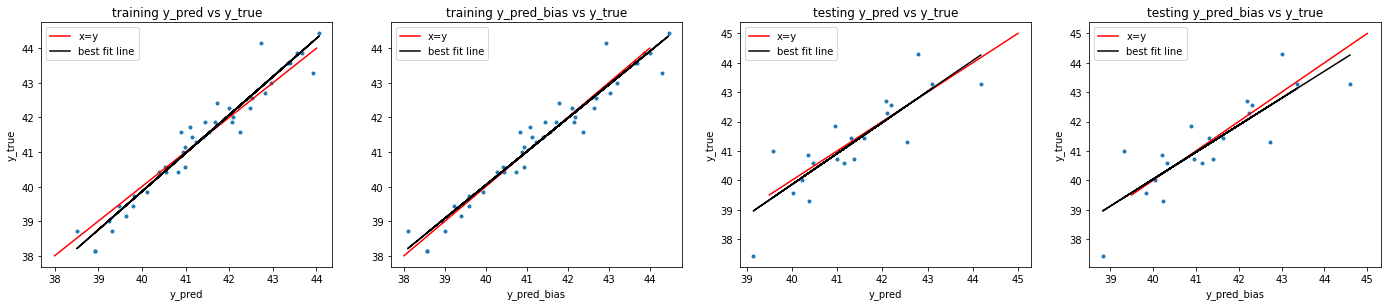

In [202]:
y_train_pred=pipe1.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipe1.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39.5,45],[39.5,45],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39.5,45],[39.5,45],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



Text(0.5, 1.0, 'Testing dataset (high risk)')

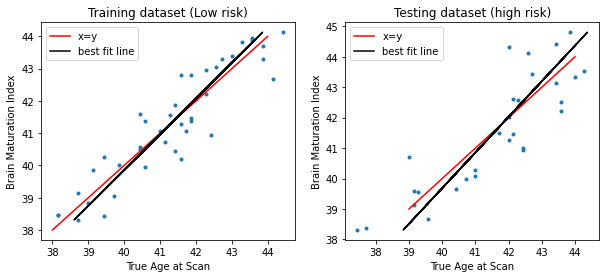

In [219]:
y_train_pred=rfecv.predict(X_trainval)
f,(ax2,ax4)=plt.subplots(1,2,figsize=(10,4))
lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_trainval,y_train_pred_bias,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(lin_reg.predict(y_train_pred_bias.reshape(-1,1)),y_train_pred_bias,'k-',label='best fit line')
ax2.set_xlabel('True Age at Scan')
ax2.set_ylabel('Brain Maturation Index')
ax2.legend()
ax2.set_title('Training dataset (Low risk)')

y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
y_high_risk_pred_bias=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_diff'])
ax4.plot(y_high_risk,y_high_risk_pred_bias,'.')
ax4.plot([39,44],[39,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_high_risk_pred_bias.reshape(-1,1),y_high_risk)
ax4.plot(lin_reg.predict(y_high_risk_pred_bias.reshape(-1,1)),y_high_risk_pred_bias,'k-',label='best fit line')
ax4.set_ylabel('Brain Maturation Index')
ax4.set_xlabel('True Age at Scan')
ax4.legend()
ax4.set_title('Testing dataset (high risk)')

# y_pred_bias=y_pred+y_pred*coef+inter
# ax4.plot(y_test,y_pred_bias,'.')
# ax4.plot([39,44],[39,44],'r-',label='x=y')
# lin_reg=LinearRegression()
# lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
# ax4.plot(lin_reg.predict(y_pred_bias.reshape(-1,1)),y_pred_bias,'k-',label='best fit line')
# ax4.set_ylabel('Brain Maturation Index')
# ax4.set_xlabel('True Age at Scan')
# ax4.legend()
# ax4.set_title('testing dataset')

In [220]:
MLtraining.print_scores(y_high_risk_pred_dict[1],y_high_risk)

{'r2': 0.7786538184223807,
 'MAE': 0.7015626742977661,
 'RMSE': 0.8791099841848182,
 'Correlation': 0.8835256059478367,
 'p_value': 2.178347782273046e-10}

In [223]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA,residual
0,42.892545,43.316275,42.525032,42.911284,43.571429,-0.660144
1,40.043027,40.564691,40.269008,40.292242,41.000000,-0.707758
2,42.246272,42.990188,43.446434,42.894298,42.714286,0.180012
3,41.815529,43.143191,42.576348,42.511689,42.285714,0.225975
4,43.128519,43.321559,43.324051,43.258043,44.000000,-0.741957
5,41.836585,41.806236,42.035618,41.892813,42.000000,-0.107187
6,41.515804,40.460051,41.446662,41.140839,42.142857,-1.002018
7,42.672084,43.723399,43.524042,43.306509,44.285714,-0.979206
8,41.519131,41.355465,41.271372,41.381989,42.000000,-0.618011
9,40.891328,41.608440,40.925179,41.141649,42.428571,-1.286923


In [224]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference.loc[:,'residual'],adjusted_prs_score_scaled_high_risk))[0],
'p-value':(pearsonr(brain_age_difference.loc[:,'residual'],adjusted_prs_score_scaled_high_risk))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.509151,0.00479


Text(0, 0.5, 'BMI - PMA')

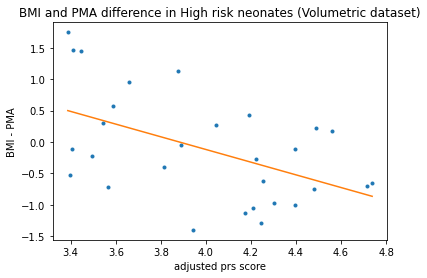

In [225]:
plt.plot(adjusted_prs_score_scaled_high_risk,brain_age_difference.loc[:,'residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score_scaled_high_risk.reshape(-1,1),brain_age_difference.loc[:,'residual'].values)
plt.plot(adjusted_prs_score_scaled_high_risk,lin_reg.predict(adjusted_prs_score_scaled_high_risk.reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.title('BMI and PMA difference in High risk neonates (Volumetric dataset)')
plt.ylabel('BMI - PMA')

### Checking features

In [211]:
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,"'1 Precentral_L 2001'":"'93 Vermis'"].columns  
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)

(93,)


In [212]:
inner_folds_selection=pd.DataFrame(inner_fold_feature_selection_logs)
inner_folds_selection=inner_folds_selection[(inner_folds_selection[0]==True)&(inner_folds_selection[1]==True)&(inner_folds_selection[2]==True)]

In [281]:
# coefs_of_prs_pval=pipe0.named_steps['select_p_Val'].coefficients[pipe0.named_steps['select_p_Val'].p_value<0.05]
# ROIs_coef=pd.DataFrame(zip(ROIs_combination_remove_zeros,coefs_of_prs_pval,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Region','PRS_coef','PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3'])
# ROIs_coef['PMA_Mean_Coef']=ROIs_coef[['PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3']].mean(axis=1)
# # ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['Mean_Coef'].abs().sort_values(ascending=False).index)
# ROIs_coef=ROIs_coef.iloc[inner_folds_selection.index,:]
# ROIs_coef['PRS*PMA_Coef']=ROIs_coef['PRS_coef']*ROIs_coef['PMA_Mean_Coef']

In [215]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_remove_zeros,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Region','PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3'])
ROIs_coef['PMA_Mean_Coef']=ROIs_coef[['PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3']].mean(axis=1)
# ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['Mean_Coef'].abs().sort_values(ascending=False).index)
ROIs_coef=ROIs_coef.iloc[inner_folds_selection.index,:]

In [216]:
ROIs_coef_RidgeCV_VOLUME=ROIs_coef

In [287]:
# merged_feature_dict_strings=pipe0.named_steps['remove_correlation'].merged_feature_dict_strings
# ROIs_coef_RidgeCV_VOLUME['Merged_Feature']=[False if not merged_feature_dict_strings[i] else True for i in ROIs_coef_RidgeCV_VOLUME['Region']]

In [218]:
ROIs_coef_RidgeCV_VOLUME

,Region,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef
15,'16 Frontal_Inf_Orb_R 2322',0.206308,0.147534,0.208576,0.187473
29,'30 Insula_R 3002',-0.251770,-0.186658,-0.300394,-0.246274
65,'66 Angular_R 6222',0.187992,0.141934,0.155778,0.161901
91,'92 Cerebelum_R 9002',0.261277,0.231379,0.370334,0.287663


In [242]:
model_summary.loc[list(ROIs_coef_RidgeCV_VOLUME['Region']),:]

,const_coef,const_pval,Gender_coef,Gender_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,GA_struc_coef,GA_struc_pval,PMA_struc_coef,PMA_struc_pval,Anc_PC1_coef,Anc_PC1_pval,Anc_PC2_coef,Anc_PC2_pval,Anc_PC3_coef,Anc_PC3_pval,PRS_0.05_coef,PRS_0.05_pval
'16 Frontal_Inf_Orb_R 2322',0.010072,0.850005,-0.020011,0.799598,0.825159,6.387477e-27,0.044958,0.348505,0.092349,2.007617e-01,-0.043021,0.269652,-0.053489,0.137698,0.020181,0.580461,-0.043638,0.252370
'30 Insula_R 3002',0.155727,0.006294,-0.309404,0.000283,0.967843,1.046137e-30,0.076889,0.129987,-0.231211,2.759607e-03,0.060468,0.142521,0.036651,0.334488,-0.034759,0.367871,-0.004312,0.914524
'66 Angular_R 6222',0.002398,0.966112,-0.004764,0.954517,0.750497,5.399701e-22,-0.052696,0.299914,0.205397,7.825726e-03,0.007031,0.864528,-0.020138,0.596681,0.003736,0.923044,0.007657,0.849344
'92 Cerebelum_R 9002',-0.013491,0.791823,0.026804,0.723110,0.517286,6.006177e-15,-0.073636,0.110628,0.490667,5.035035e-11,0.017433,0.640543,0.008456,0.806094,-0.065949,0.061272,0.057372,0.117594
